In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import arch
from arch.unitroot import ADF
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

In [2]:
seel = yf.download(tickers="SEEL", period="7d", interval="1m")
zyne = yf.download(tickers="ZYNE", period="7d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
seel_adf = ADF(seel["Close"])
print(seel_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.538
P-value                         0.515
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [4]:
zyne_adf = ADF(zyne["Close"])
print(zyne_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.612
P-value                         0.477
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [5]:
zyne_returns = 100 * (zyne["Close"].pct_change().dropna())
zyne_arch = arch_model(zyne_returns, dist="skewt")
zyne_res = zyne_arch.fit()
print(zyne_res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 575.8160837829316
Iteration:      2,   Func. Count:     20,   Neg. LLF: 575.8076952192446
Iteration:      3,   Func. Count:     30,   Neg. LLF: 575.4386121574498
Iteration:      4,   Func. Count:     40,   Neg. LLF: 574.9343756027884
Iteration:      5,   Func. Count:     50,   Neg. LLF: 574.8126027211337
Iteration:      6,   Func. Count:     59,   Neg. LLF: 574.3069643554791
Iteration:      7,   Func. Count:     68,   Neg. LLF: 573.5500355769292
Iteration:      8,   Func. Count:     77,   Neg. LLF: 573.2935537660994
Iteration:      9,   Func. Count:     86,   Neg. LLF: 573.0680272872453
Iteration:     10,   Func. Count:     95,   Neg. LLF: 572.8785440476101
Iteration:     11,   Func. Count:    104,   Neg. LLF: 572.7207194033945
Iteration:     12,   Func. Count:    113,   Neg. LLF: 572.6919368319707
Iteration:     13,   Func. Count:    122,   Neg. LLF: 572.6880881767479
Iteration:     14,   Func. Count:    130,   Neg. LLF: 572.687737

In [6]:
zyne[-117:]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-27 15:57:00-04:00,1.3700,1.370,1.3700,1.370,1.370,645
2022-04-27 15:58:00-04:00,1.3700,1.370,1.3700,1.370,1.370,2005
2022-04-27 15:59:00-04:00,1.3750,1.380,1.3700,1.375,1.375,2138
2022-04-28 09:30:00-04:00,1.4000,1.400,1.4000,1.400,1.400,3220
2022-04-28 09:31:00-04:00,1.3900,1.390,1.3900,1.390,1.390,260
...,...,...,...,...,...,...
2022-04-28 15:18:00-04:00,1.3900,1.390,1.3900,1.390,1.390,0
2022-04-28 15:25:00-04:00,1.3950,1.395,1.3950,1.395,1.395,135
2022-04-28 15:26:00-04:00,1.3912,1.395,1.3912,1.395,1.395,220


C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


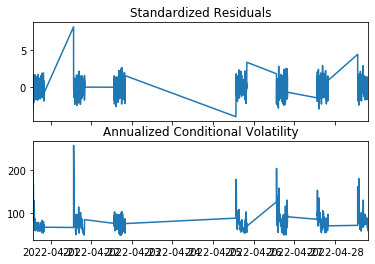

In [7]:
fig = zyne_res.plot(scale=252*120)

In [8]:
zyne_res.conditional_volatility

Datetime
2022-04-20 09:33:00-04:00    0.715008
2022-04-20 09:35:00-04:00    1.148691
2022-04-20 09:36:00-04:00    1.021466
2022-04-20 09:40:00-04:00    0.920028
2022-04-20 09:45:00-04:00    0.954885
                               ...   
2022-04-28 15:18:00-04:00    0.386268
2022-04-28 15:25:00-04:00    0.385953
2022-04-28 15:26:00-04:00    0.397107
2022-04-28 15:28:00-04:00    0.366175
2022-04-28 15:32:25-04:00    0.342534
Name: cond_vol, Length: 1095, dtype: float64

In [9]:
zyne_forecasts = zyne_res.forecast(reindex=False)
print(zyne_forecasts.mean.iloc[-3:])
print(zyne_forecasts.residual_variance.iloc[-3:])
print(zyne_forecasts.variance.iloc[-3:])

                               h.1
Datetime                          
2022-04-28 15:32:25-04:00 -0.01552
                                h.1
Datetime                           
2022-04-28 15:32:25-04:00  0.105441
                                h.1
Datetime                           
2022-04-28 15:32:25-04:00  0.105441


In [10]:
zyne_forecasts.variance["h.1"][0]

0.10544066794746688

In [11]:
np.sqrt(0.136057)

0.3688590516715023

In [13]:
def full_month(ticker):
    today = datetime.datetime.now()
    four = (today - datetime.timedelta(days = 28)).date().strftime("%Y-%m-%d")
    three = (today - datetime.timedelta(days = 21)).date().strftime("%Y-%m-%d")
    two = (today - datetime.timedelta(days = 14)).date().strftime("%Y-%m-%d")
    one = (today - datetime.timedelta(days = 7)).date().strftime("%Y-%m-%d")
    t43 = yf.download(tickers=ticker, start=four, end=three, interval="1m")
    t32 = yf.download(tickers=ticker, start=three, end=two, interval="1m")
    t21 = yf.download(tickers=ticker, start=two, end=one, interval="1m")
    t10 = yf.download(tickers=ticker, period="7d", interval="1m")
    ticker = pd.concat([t43, t32, t21, t10])
    return ticker

In [92]:
def next_min_bound(ticker, st_devs):
    ticker = full_month(ticker)
    adf = ADF(ticker["Close"])
    print(adf.summary().as_text())
    returns = 100 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    print(result.summary())
    print(result.conditional_volatility)
    var = result.forecast(reindex=False).variance["h.1"][0]
    return np.sqrt(var)*st_devs

In [93]:
def adf_full_month(ticker):
    tick = full_month(ticker)
    adf = ADF(tick["Close"])
    print(adf.summary().as_text())

In [94]:
def conditional_vol(ticker):
    ticker = full_month(ticker)
    returns = 10000 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    return ticker, returns, result.conditional_volatility

In [111]:
def get_hurst_exponent(data):
    time_series = data["Close"].values
    lags = range(2, 12)
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [95]:
sedg, sedg_returns, sedg_vol = conditional_vol("SEDG")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 33516.28242942499
Iteration:      2,   Func. Count:     17,   Neg. LLF: 33001.588619592076
Iteration:      3,   Func. Count:     26,   Neg. LLF: 32687.843518454938
Iteration:      4,   Func. Count:     35,   Neg. LLF: 32542.917386698748
Iteration:      5,   Func. Count:     44,   Neg. LLF: 32385.711122769222
Iteration:      6,   Func. Count:     53,   Neg. LLF: 32258.931539053003
Iteration:      7,   Func. Count:     62,   Neg. LLF: 32159.742167511333
Iteration:      8,   Func. Count:     71,   Neg. LLF: 32060.896994000028
Iteration:      9,   Func. Count:     80,   Neg. LLF: 32012.564902393282
Iteration:     10,   Func. Count:     89,   Neg. LLF: 31949.43617428

In [96]:
sedg_vol

Datetime
2022-03-31 09:31:00-04:00    33.278833
2022-03-31 09:32:00-04:00    42.847188
2022-03-31 09:33:00-04:00    38.568736
2022-03-31 09:34:00-04:00    36.149112
2022-03-31 09:35:00-04:00    32.535416
                               ...    
2022-04-28 15:56:00-04:00    14.320648
2022-04-28 15:57:00-04:00    16.029995
2022-04-28 15:58:00-04:00    15.407480
2022-04-28 15:59:00-04:00    14.767292
2022-04-28 16:00:00-04:00    16.261976
Name: cond_vol, Length: 7363, dtype: float64

In [97]:
sedg_returns

Datetime
2022-03-31 09:31:00-04:00    78.258397
2022-03-31 09:32:00-04:00    -9.959457
2022-03-31 09:33:00-04:00   -26.972296
2022-03-31 09:34:00-04:00    -3.879948
2022-03-31 09:35:00-04:00   -39.062500
                               ...    
2022-04-28 15:56:00-04:00    20.887474
2022-04-28 15:57:00-04:00    -7.472468
2022-04-28 15:58:00-04:00     4.722730
2022-04-28 15:59:00-04:00    20.456502
2022-04-28 16:00:00-04:00   -12.170130
Name: Close, Length: 7363, dtype: float64

In [18]:
enph, enph_returns, enph_vol = conditional_vol("ENPH")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 35445.21708788174
Iteration:      2,   Func. Count:     17,   Neg. LLF: 35205.118518773204
Iteration:      3,   Func. Count:     26,   Neg. LLF: 35100.02866153782
Iteration:      4,   Func. Count:     35,   Neg. LLF: 35006.653749330566
Iteration:      5,   Func. Count:     44,   Neg. LLF: 34963.945805141615
Iteration:      6,   Func. Count:     53,   Neg. LLF: 34934.54005034952
Iteration:      7,   Func. Count:     62,   Neg. LLF: 34917.12008792271
Iteration:      8,   Func. Count:     71,   Neg. LLF: 34895.04504063483
Iteration:      9,   Func. Count:     80,   Neg. LLF: 34883.53412864988
Iteration:     10,   Func. Count:     89,   Neg. LLF: 34855.43324750117
I

In [19]:
sedg_differential = sedg_returns + sedg_vol
sedg_times = sedg_differential[sedg_differential < 0].reset_index()

In [20]:
enph = enph.reset_index().reset_index()

In [21]:
for i in range(1, 30):
    trimmed = enph[:-i]
    entries = trimmed.loc[trimmed["Datetime"].isin(sedg_times["Datetime"])].reset_index(drop=True)
    sell = enph.loc[enph["index"].isin(entries["index"] + i)]
    profit = sum(sell["Close"]) - sum(entries["Close"])
    print(profit)

-36.35142517089844
-60.594085693359375
-78.19619750976562
-90.32392883300781
-67.17697143554688
-67.38670349121094
-51.09120178222656
-61.11332702636719
-21.3421630859375
-27.488967895507812
-27.754913330078125
-31.169448852539062
-18.291824340820312
-21.695556640625
-51.53700256347656
-75.29530334472656
-72.53779602050781
-93.23025512695312
-114.10971069335938
-132.78147888183594
-153.67083740234375
-165.21749877929688
-159.64903259277344
-183.72959899902344
-226.4361572265625
-219.40658569335938
-237.77081298828125
-243.9665985107422
-253.22593688964844


In [22]:
def t1_to_t2_test(ticker1, ticker2, window):
    t1, t1_returns, t1_vol = conditional_vol(ticker1)
    t2, t2_returns, t2_vol = conditional_vol(ticker2)
    t1_diff = t1_returns + t1_vol
    t1_times = t1_diff[t1_diff < 0].reset_index()
    t2 = t2.reset_index().reset_index()
    for i in range(1, window + 1):
        trimmed = t2[:-i]
        entries = trimmed.loc[trimmed["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
        sell = t2.loc[t2["index"].isin(entries["index"] + i)]
        profit = sum(sell["Close"]) - sum(entries["Close"])
        print(f"{profit} profit when held for {i} minutes")

In [34]:
def t1_to_t2_directional(ticker1, ticker2, window, correlated):
    t1, t1_returns, t1_vol = conditional_vol(ticker1)
    t2, t2_returns, t2_vol = conditional_vol(ticker2)
    if correlated:
        t1_diff = t1_returns - t1_vol
        t1_times = t1_diff[t1_diff > 0].reset_index()
    else:
        t1_diff = t1_returns + t1_vol
        t1_times = t1_diff[t1_diff < 0].reset_index()
    t2 = t2.reset_index().reset_index()
    for i in range(1, window + 1):
        trimmed = t2[:-i]
        entries = trimmed.loc[trimmed["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
        sell = t2.loc[t2["index"].isin(entries["index"] + i)]
        profit = sum(sell["Close"]) - sum(entries["Close"])
        print(f"{profit} profit when held for {i} minutes")

In [114]:
def t1_to_t2_dynamic(ticker1, ticker2, correlated, std_ct):
    t1, t1_returns, t1_vol = conditional_vol(ticker1)
    t2, t2_returns, t2_vol = conditional_vol(ticker2)
    hurst = get_hurst_exponent(t2)
    if correlated:
        t1_diff = t1_returns - t1_vol
        t1_times = t1_diff[t1_diff > 0].reset_index()
    else:
        t1_diff = t1_returns + t1_vol
        t1_times = t1_diff[t1_diff < 0].reset_index()
    t2 = t2.reset_index().reset_index()
    t2_vol = t2_vol.reset_index()
    entries = t2.loc[t2["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
    entry_vols = t2_vol.loc[t2_vol["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
    entries["Current Vol"] = entry_vols["cond_vol"]
    ctime = entries["Datetime"][0]
    profit = 0
    for index, row in entries.iterrows():
        if row["Datetime"] < ctime:
            continue
        open_time = row["Datetime"]
        cost = row["Close"]
        print(f"Purchased for {cost} at {open_time}")
        bound = (row["Current Vol"]/10000)*cost
        remainder = t2.loc[t2["index"] > row["index"]]
        for i, r in remainder.iterrows():
            if abs(r["Close"] - cost) >= bound*std_ct*(2*hurst):
                sale = r["Close"]
                ctime = r["Datetime"]
                print(f"Sold for {sale} at {ctime}")
                profit += (sale - cost)
                break
    return profit

In [116]:
t1_to_t2_dynamic("SEDG", "ENPH", False, 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 33516.28242942499
Iteration:      2,   Func. Count:     17,   Neg. LLF: 33001.588619592076
Iteration:      3,   Func. Count:     26,   Neg. LLF: 32687.843518454938
Iteration:      4,   Func. Count:     35,   Neg. LLF: 32542.917386698748
Iteration:      5,   Func. Count:     44,   Neg. LLF: 32385.711122769222
Iteration:      6,   Func. Count:     53,   Neg. LLF: 32258.931539053003
Iteration:      7,   Func. Count:     62,   Neg. LLF: 32159.742167511333
Iteration:      8,   Func. Count:     71,   Neg. LLF: 32060.896994000028
Iteration:      9,   Func. Count:     80,   Neg. LLF: 32012.564902393282
Iteration:     10,   Func. Count:     89,   Neg. LLF: 31949.43617428

Sold for 200.77999877929688 at 2022-03-31 10:42:00-04:00
Purchased for 202.6999969482422 at 2022-03-31 10:48:00-04:00
Sold for 203.19500732421875 at 2022-03-31 10:50:00-04:00
Purchased for 202.97000122070312 at 2022-03-31 10:51:00-04:00
Sold for 202.09060668945312 at 2022-03-31 10:52:00-04:00
Purchased for 202.0500030517578 at 2022-03-31 10:53:00-04:00
Sold for 202.40499877929688 at 2022-03-31 10:57:00-04:00
Purchased for 202.02000427246094 at 2022-03-31 11:01:00-04:00
Sold for 201.5399932861328 at 2022-03-31 11:02:00-04:00
Purchased for 201.3699951171875 at 2022-03-31 11:03:00-04:00
Sold for 201.78500366210938 at 2022-03-31 11:09:00-04:00
Purchased for 201.61000061035156 at 2022-03-31 11:23:00-04:00
Sold for 201.3155059814453 at 2022-03-31 11:24:00-04:00
Purchased for 201.3155059814453 at 2022-03-31 11:24:00-04:00
Sold for 201.56700134277344 at 2022-03-31 11:29:00-04:00
Purchased for 202.27000427246094 at 2022-03-31 11:37:00-04:00
Sold for 202.0 at 2022-03-31 11:38:00-04:00
Purchased 

Sold for 212.22999572753906 at 2022-04-04 10:17:00-04:00
Purchased for 212.22999572753906 at 2022-04-04 10:17:00-04:00
Sold for 210.86000061035156 at 2022-04-04 10:18:00-04:00
Purchased for 210.86000061035156 at 2022-04-04 10:18:00-04:00
Sold for 210.10000610351562 at 2022-04-04 10:20:00-04:00
Purchased for 211.8000030517578 at 2022-04-04 10:28:00-04:00
Sold for 212.41000366210938 at 2022-04-04 10:30:00-04:00
Purchased for 211.99000549316406 at 2022-04-04 10:32:00-04:00
Sold for 212.3800048828125 at 2022-04-04 10:34:00-04:00
Purchased for 215.1699981689453 at 2022-04-04 10:56:00-04:00
Sold for 214.64999389648438 at 2022-04-04 10:57:00-04:00
Purchased for 216.42149353027344 at 2022-04-04 11:08:00-04:00
Sold for 215.91000366210938 at 2022-04-04 11:11:00-04:00
Purchased for 215.91000366210938 at 2022-04-04 11:11:00-04:00
Sold for 216.24000549316406 at 2022-04-04 11:12:00-04:00
Purchased for 216.5 at 2022-04-04 11:13:00-04:00
Sold for 216.17999267578125 at 2022-04-04 11:16:00-04:00
Purchas

Sold for 199.97999572753906 at 2022-04-06 09:50:00-04:00
Purchased for 201.1199951171875 at 2022-04-06 09:57:00-04:00
Sold for 201.52000427246094 at 2022-04-06 09:58:00-04:00
Purchased for 200.38670349121094 at 2022-04-06 10:01:00-04:00
Sold for 200.88999938964844 at 2022-04-06 10:02:00-04:00
Purchased for 200.50999450683594 at 2022-04-06 10:03:00-04:00
Sold for 201.22999572753906 at 2022-04-06 10:04:00-04:00
Purchased for 200.77999877929688 at 2022-04-06 10:08:00-04:00
Sold for 201.3699951171875 at 2022-04-06 10:11:00-04:00
Purchased for 201.25 at 2022-04-06 10:12:00-04:00
Sold for 201.7899932861328 at 2022-04-06 10:13:00-04:00
Purchased for 201.82000732421875 at 2022-04-06 10:17:00-04:00
Sold for 202.22000122070312 at 2022-04-06 10:20:00-04:00
Purchased for 201.27999877929688 at 2022-04-06 10:23:00-04:00
Sold for 200.92990112304688 at 2022-04-06 10:25:00-04:00
Purchased for 200.21499633789062 at 2022-04-06 10:26:00-04:00
Sold for 199.75999450683594 at 2022-04-06 10:27:00-04:00
Purcha

Sold for 203.19000244140625 at 2022-04-07 12:53:00-04:00
Purchased for 202.88999938964844 at 2022-04-07 12:54:00-04:00
Sold for 202.5500030517578 at 2022-04-07 12:55:00-04:00
Purchased for 202.27000427246094 at 2022-04-07 12:57:00-04:00
Sold for 202.77999877929688 at 2022-04-07 12:59:00-04:00
Purchased for 205.9698944091797 at 2022-04-07 13:32:00-04:00
Sold for 205.6699981689453 at 2022-04-07 13:33:00-04:00
Purchased for 205.8126983642578 at 2022-04-07 13:37:00-04:00
Sold for 206.22000122070312 at 2022-04-07 13:40:00-04:00
Purchased for 205.88999938964844 at 2022-04-07 13:51:00-04:00
Sold for 206.125 at 2022-04-07 13:52:00-04:00
Purchased for 206.1580047607422 at 2022-04-07 13:54:00-04:00
Sold for 206.9149932861328 at 2022-04-07 13:55:00-04:00
Purchased for 207.07000732421875 at 2022-04-07 14:03:00-04:00
Sold for 207.49000549316406 at 2022-04-07 14:04:00-04:00
Purchased for 206.9600067138672 at 2022-04-07 14:05:00-04:00
Sold for 206.64999389648438 at 2022-04-07 14:07:00-04:00
Purchased

Sold for 190.94000244140625 at 2022-04-11 10:21:00-04:00
Purchased for 189.88999938964844 at 2022-04-11 10:28:00-04:00
Sold for 189.19000244140625 at 2022-04-11 10:30:00-04:00
Purchased for 190.1699981689453 at 2022-04-11 10:35:00-04:00
Sold for 189.88499450683594 at 2022-04-11 10:36:00-04:00
Purchased for 189.88499450683594 at 2022-04-11 10:36:00-04:00
Sold for 189.14999389648438 at 2022-04-11 10:37:00-04:00
Purchased for 189.14999389648438 at 2022-04-11 10:37:00-04:00
Sold for 188.55999755859375 at 2022-04-11 10:38:00-04:00
Purchased for 187.32000732421875 at 2022-04-11 10:46:00-04:00
Sold for 186.97999572753906 at 2022-04-11 10:48:00-04:00
Purchased for 186.4499969482422 at 2022-04-11 10:49:00-04:00
Sold for 186.064697265625 at 2022-04-11 10:51:00-04:00
Purchased for 186.064697265625 at 2022-04-11 10:51:00-04:00
Sold for 186.83999633789062 at 2022-04-11 10:53:00-04:00
Purchased for 185.7899932861328 at 2022-04-11 10:57:00-04:00
Sold for 185.3800048828125 at 2022-04-11 10:58:00-04:00

Sold for 188.27999877929688 at 2022-04-13 09:51:00-04:00
Purchased for 188.60000610351562 at 2022-04-13 09:56:00-04:00
Sold for 188.88999938964844 at 2022-04-13 09:57:00-04:00
Purchased for 188.5500030517578 at 2022-04-13 10:00:00-04:00
Sold for 189.41000366210938 at 2022-04-13 10:04:00-04:00
Purchased for 189.0 at 2022-04-13 10:08:00-04:00
Sold for 188.35000610351562 at 2022-04-13 10:09:00-04:00
Purchased for 189.91000366210938 at 2022-04-13 10:34:00-04:00
Sold for 189.71539306640625 at 2022-04-13 10:35:00-04:00
Purchased for 190.1083984375 at 2022-04-13 10:40:00-04:00
Sold for 190.47500610351562 at 2022-04-13 10:41:00-04:00
Purchased for 190.35000610351562 at 2022-04-13 11:01:00-04:00
Sold for 190.58999633789062 at 2022-04-13 11:02:00-04:00
Purchased for 192.356201171875 at 2022-04-13 11:28:00-04:00
Sold for 192.1300048828125 at 2022-04-13 11:31:00-04:00
Purchased for 191.5800018310547 at 2022-04-13 11:39:00-04:00
Sold for 191.77000427246094 at 2022-04-13 11:40:00-04:00
Purchased for

Sold for 190.1699981689453 at 2022-04-18 15:42:00-04:00
Purchased for 189.7899932861328 at 2022-04-18 15:45:00-04:00
Sold for 189.6199951171875 at 2022-04-18 15:46:00-04:00
Purchased for 189.6199951171875 at 2022-04-18 15:46:00-04:00
Sold for 189.27589416503906 at 2022-04-18 15:48:00-04:00
Purchased for 189.27589416503906 at 2022-04-18 15:48:00-04:00
Sold for 189.10850524902344 at 2022-04-18 15:49:00-04:00
Purchased for 188.6999969482422 at 2022-04-19 09:31:00-04:00
Sold for 188.27999877929688 at 2022-04-19 09:32:00-04:00
Purchased for 188.27999877929688 at 2022-04-19 09:32:00-04:00
Sold for 187.8800048828125 at 2022-04-19 09:33:00-04:00
Purchased for 187.8800048828125 at 2022-04-19 09:33:00-04:00
Sold for 189.0500030517578 at 2022-04-19 09:34:00-04:00
Purchased for 187.36500549316406 at 2022-04-19 09:38:00-04:00
Sold for 186.27000427246094 at 2022-04-19 09:39:00-04:00
Purchased for 186.27000427246094 at 2022-04-19 09:39:00-04:00
Sold for 185.5601043701172 at 2022-04-19 09:40:00-04:00


Sold for 185.8300018310547 at 2022-04-20 10:46:00-04:00
Purchased for 185.8300018310547 at 2022-04-20 10:46:00-04:00
Sold for 185.36000061035156 at 2022-04-20 10:47:00-04:00
Purchased for 185.73500061035156 at 2022-04-20 10:57:00-04:00
Sold for 186.0800018310547 at 2022-04-20 10:58:00-04:00
Purchased for 185.60000610351562 at 2022-04-20 11:00:00-04:00
Sold for 185.3800048828125 at 2022-04-20 11:01:00-04:00
Purchased for 184.15499877929688 at 2022-04-20 11:08:00-04:00
Sold for 183.8249969482422 at 2022-04-20 11:10:00-04:00
Purchased for 182.74000549316406 at 2022-04-20 11:13:00-04:00
Sold for 182.52999877929688 at 2022-04-20 11:14:00-04:00
Purchased for 182.66000366210938 at 2022-04-20 11:20:00-04:00
Sold for 182.88999938964844 at 2022-04-20 11:21:00-04:00
Purchased for 182.3300018310547 at 2022-04-20 11:32:00-04:00
Sold for 182.1699981689453 at 2022-04-20 11:34:00-04:00
Purchased for 182.1699981689453 at 2022-04-20 11:34:00-04:00
Sold for 181.98959350585938 at 2022-04-20 11:35:00-04:00

Sold for 156.44000244140625 at 2022-04-21 13:12:00-04:00
Purchased for 156.32000732421875 at 2022-04-21 13:15:00-04:00
Sold for 155.9600067138672 at 2022-04-21 13:17:00-04:00
Purchased for 155.9600067138672 at 2022-04-21 13:17:00-04:00
Sold for 157.17430114746094 at 2022-04-21 13:20:00-04:00
Purchased for 157.44500732421875 at 2022-04-21 13:25:00-04:00
Sold for 156.98500061035156 at 2022-04-21 13:27:00-04:00
Purchased for 158.30999755859375 at 2022-04-21 13:34:00-04:00
Sold for 157.82000732421875 at 2022-04-21 13:38:00-04:00
Purchased for 157.9499969482422 at 2022-04-21 13:41:00-04:00
Sold for 157.5500030517578 at 2022-04-21 13:45:00-04:00
Purchased for 157.5500030517578 at 2022-04-21 13:45:00-04:00
Sold for 157.2550048828125 at 2022-04-21 13:47:00-04:00
Purchased for 158.11000061035156 at 2022-04-21 14:03:00-04:00
Sold for 157.9499969482422 at 2022-04-21 14:07:00-04:00
Purchased for 158.0 at 2022-04-21 14:11:00-04:00
Sold for 158.14500427246094 at 2022-04-21 14:13:00-04:00
Purchased f

Sold for 156.59280395507812 at 2022-04-25 10:45:00-04:00
Purchased for 155.77000427246094 at 2022-04-25 10:46:00-04:00
Sold for 156.07000732421875 at 2022-04-25 10:48:00-04:00
Purchased for 155.13999938964844 at 2022-04-25 10:52:00-04:00
Sold for 154.47999572753906 at 2022-04-25 10:56:00-04:00
Purchased for 154.47999572753906 at 2022-04-25 10:56:00-04:00
Sold for 154.72999572753906 at 2022-04-25 10:57:00-04:00
Purchased for 154.74000549316406 at 2022-04-25 10:59:00-04:00
Sold for 154.25999450683594 at 2022-04-25 11:00:00-04:00
Purchased for 153.66000366210938 at 2022-04-25 11:01:00-04:00
Sold for 153.99000549316406 at 2022-04-25 11:03:00-04:00
Purchased for 154.30999755859375 at 2022-04-25 11:04:00-04:00
Sold for 153.75999450683594 at 2022-04-25 11:05:00-04:00
Purchased for 154.46499633789062 at 2022-04-25 11:11:00-04:00
Sold for 153.77999877929688 at 2022-04-25 11:13:00-04:00
Purchased for 153.77999877929688 at 2022-04-25 11:13:00-04:00
Sold for 153.4600067138672 at 2022-04-25 11:15:0

Sold for 170.41009521484375 at 2022-04-27 10:14:00-04:00
Purchased for 168.82000732421875 at 2022-04-27 10:19:00-04:00
Sold for 169.86000061035156 at 2022-04-27 10:21:00-04:00
Purchased for 170.24000549316406 at 2022-04-27 10:26:00-04:00
Sold for 168.875 at 2022-04-27 10:27:00-04:00
Purchased for 168.875 at 2022-04-27 10:27:00-04:00
Sold for 168.25010681152344 at 2022-04-27 10:29:00-04:00
Purchased for 168.25010681152344 at 2022-04-27 10:29:00-04:00
Sold for 167.0800018310547 at 2022-04-27 10:32:00-04:00
Purchased for 169.22500610351562 at 2022-04-27 10:37:00-04:00
Sold for 170.3699951171875 at 2022-04-27 10:39:00-04:00
Purchased for 169.52000427246094 at 2022-04-27 10:41:00-04:00
Sold for 170.16000366210938 at 2022-04-27 10:43:00-04:00
Purchased for 170.00999450683594 at 2022-04-27 10:44:00-04:00
Sold for 170.35000610351562 at 2022-04-27 10:45:00-04:00
Purchased for 169.02000427246094 at 2022-04-27 10:58:00-04:00
Sold for 169.75999450683594 at 2022-04-27 11:00:00-04:00
Purchased for 1

Sold for 163.66700744628906 at 2022-04-28 13:55:00-04:00
Purchased for 163.69000244140625 at 2022-04-28 14:00:00-04:00
Sold for 163.97999572753906 at 2022-04-28 14:02:00-04:00
Purchased for 163.14999389648438 at 2022-04-28 14:12:00-04:00
Sold for 163.39999389648438 at 2022-04-28 14:13:00-04:00
Purchased for 163.02999877929688 at 2022-04-28 14:15:00-04:00
Sold for 163.2657928466797 at 2022-04-28 14:16:00-04:00
Purchased for 164.22000122070312 at 2022-04-28 14:27:00-04:00
Sold for 164.35499572753906 at 2022-04-28 14:28:00-04:00
Purchased for 164.77999877929688 at 2022-04-28 14:31:00-04:00
Sold for 165.2100067138672 at 2022-04-28 14:33:00-04:00
Purchased for 166.0 at 2022-04-28 14:42:00-04:00
Sold for 166.1750030517578 at 2022-04-28 14:43:00-04:00
Purchased for 165.91000366210938 at 2022-04-28 14:54:00-04:00
Sold for 165.6699981689453 at 2022-04-28 14:55:00-04:00
Purchased for 165.6699981689453 at 2022-04-28 14:55:00-04:00
Sold for 165.82000732421875 at 2022-04-28 14:58:00-04:00
Purchased

53.26979064941406

In [108]:
get_hurst_exponent("SEDG")

[*********************100%***********************]  1 of 1 completed


0.48029566744607494

In [23]:
adf_full_month("ENPH")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.875
P-value                         0.796
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [24]:
t1_to_t2_test("SEDG", "ENPH", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 31701.907198256427
Iteration:      2,   Func. Count:     18,   Neg. LLF: 31617.181350762727
Iteration:      3,   Func. Count:     27,   Neg. LLF: 31538.18753637231
Iteration:      4,   Func. Count:     37,   Neg. LLF: 31507.617888410743
Iteration:      5,   Func. Count:     46,   Neg. LLF: 31482.261815067013
Iteration:      6,   Func. Count:     55,   Neg. LLF: 31468.54024936546
Iteration:      7,   Func. Count:     64,   Neg. LLF: 31461.269212323186
Iteration:      8,   Func. Count:     73,   Neg. LLF: 31454.120002612373
Iteration:      9,   Func. Count:     82,   Neg. LLF: 31446.05728176792
Iteration:     10,   Func. Count:     91,   Neg. LLF: 31433.4536190355

In [37]:
t1_to_t2_directional("SEDG", "ENPH", 30, True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 31743.249215535274
Iteration:      2,   Func. Count:     18,   Neg. LLF: 31658.667293187806
Iteration:      3,   Func. Count:     27,   Neg. LLF: 31579.772176558523
Iteration:      4,   Func. Count:     37,   Neg. LLF: 31549.283254740054
Iteration:      5,   Func. Count:     46,   Neg. LLF: 31523.656242420162
Iteration:      6,   Func. Count:     55,   Neg. LLF: 31509.81405630173
Iteration:      7,   Func. Count:     64,   Neg. LLF: 31502.579171179088
Iteration:      8,   Func. Count:     73,   Neg. LLF: 31495.4969650789
Iteration:      9,   Func. Count:     82,   Neg. LLF: 31486.966752609354
Iteration:     10,   Func. Count:     91,   Neg. LLF: 31475.0991547012

In [43]:
ctva = full_month("CTVA")
ctva_adf = ADF(ctva["Close"])
print(ctva_adf.summary().as_text())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.841
P-value                         0.807
Lags                               36
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [26]:
t1_to_t2_test("NTR", "CTVA", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 29632.113612355795
Iteration:      2,   Func. Count:     19,   Neg. LLF: 29630.19549438126
Iteration:      3,   Func. Count:     29,   Neg. LLF: 29623.596617575644
Iteration:      4,   Func. Count:     39,   Neg. LLF: 29622.62688519401
Iteration:      5,   Func. Count:     49,   Neg. LLF: 29621.367007180575
Iteration:      6,   Func. Count:     58,   Neg. LLF: 29611.71441734716
Iteration:      7,   Func. Count:     67,   Neg. LLF: 29609.309019879245
Iteration:      8,   Func. Count:     76,   Neg. LLF: 29606.511455675958
Iteration:      9,   Func. Count:     85,   Neg. LLF: 29604.313270708757
Iteration:     10,   Func. Count:     94,   Neg. LLF: 29602.9339447568

In [27]:
t1_to_t2_test("CTVA", "NTR", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 27362.143110502442
Iteration:      2,   Func. Count:     18,   Neg. LLF: 27360.037539727346
Iteration:      3,   Func. Count:     29,   Neg. LLF: 27359.680003793837
Iteration:      4,   Func. Count:     40,   Neg. LLF: 27359.140912243074
Iteration:      5,   Func. Count:     50,   Neg. LLF: 27358.825789628438
Iteration:      6,   Func. Count:     59,   Neg. LLF: 27356.64896408188
Iteration:      7,   Func. Count:     69,   Neg. LLF: 27356.008605224546
Iteration:      8,   Func. Count:     78,   Neg. LLF: 27354.95052996757
Iteration:      9,   Func. Count:     87,   Neg. LLF: 27354.192084043687
Iteration:     10,   Func. Count:     96,   Neg. LLF: 27353.646148871

In [28]:
t1_to_t2_test("ADM", "BG", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 28357.127388888908
Iteration:      2,   Func. Count:     17,   Neg. LLF: 27917.521978932193
Iteration:      3,   Func. Count:     27,   Neg. LLF: 27878.07829120211
Iteration:      4,   Func. Count:     36,   Neg. LLF: 27714.198325362107
Iteration:      5,   Func. Count:     45,   Neg. LLF: 27675.91065489137
Iteration:      6,   Func. Count:     55,   Neg. LLF: 27654.470474592315
Iteration:      7,   Func. Count:     64,   Neg. LLF: 27625.667428973895
Iteration:      8,   Func. Count:     73,   Neg. LLF: 27580.803686814143
Iteration:      9,   Func. Count:     82,   Neg. LLF: 27545.40895567213
Iteration:     10,   Func. Count:     91,   Neg. LLF: 27536.4047060446

In [29]:
t1_to_t2_test("BG", "ADM", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 28264.862675004442
Iteration:      2,   Func. Count:     18,   Neg. LLF: 28228.348742694827
Iteration:      3,   Func. Count:     28,   Neg. LLF: 28174.352959496806
Iteration:      4,   Func. Count:     37,   Neg. LLF: 28161.153164302043
Iteration:      5,   Func. Count:     46,   Neg. LLF: 28147.09889547198
Iteration:      6,   Func. Count:     55,   Neg. LLF: 28115.17148842619
Iteration:      7,   Func. Count:     64,   Neg. LLF: 28062.633927129325
Iteration:      8,   Func. Count:     73,   Neg. LLF: 28041.48301608924
Iteration:      9,   Func. Count:     82,   Neg. LLF: 27961.31405394171
Iteration:     10,   Func. Count:     91,   Neg. LLF: 27950.40518111218

In [47]:
adf_full_month("MGPI")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.536
P-value                         0.107
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [59]:
get_hurst_exponent("MGPI", 60)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 13662.63045528773
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13660.821083091403
Iteration:      3,   Func. Count:     28,   Neg. LLF: 13659.088610367031
Iteration:      4,   Func. Count:     37,   Neg. LLF: 13653.98813766011
Iteration:      5,   Func. Count:     46,   Neg. LLF: 13651.863808802691
Iteration:      6,   Func. Count:     55,   Neg. LLF: 13650.470326256427
Iteration:      7,   Func. Count:     64,   Neg. LLF: 13648.63854159852
Iteration:      8,   Func. Count:     73,   Neg. LLF: 13647.840765826959
Iteration:      9,   Func. Count:     82,   Neg. LLF: 13647.115683243423
Iteration:     10,   Func. Count:     90,   Neg. LLF: 13646.9161909265

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


0.42213171546452793
0.4267854923712493
0.43144408858813915
0.4356951202836077
0.43724439138108784
0.4375640920571604
0.43701298552861206
0.43621546150812973
0.4350962814494175
0.43387259346805823
0.43248520406766644
0.430893414383893
0.4296367340741747
0.4283584624317557
0.4271175033282887
0.4258097658551484
0.4243541461819428
0.422978900409689
0.4217526140199491
0.42072528423894184
0.4200045088277607
0.4195408548496069
0.41932869902979675
0.41939648296842813
0.41964049278566373
0.42009519121809047
0.4206626482157661
0.4213206412856492
0.4220893924613801
0.42294639969050885
0.4238758369295524
0.4248385146980278
0.4258117001523019
0.42681917820744547
0.4278162217091568
0.428771326759677
0.42970706107809764
0.4306612466281471
0.43162150269186056
0.43256632042400445
0.4334933362912503
0.4344166709429189
0.43531791411421267
0.43619832997134667
0.43704729359241273
0.4378774134223318
0.43868978839375933
0.43947031600628683
0.44022474402396855
0.44096607246041764
0.4417020594197024
0.44241973

In [31]:
t1_to_t2_test("AMRS", "MGPI", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 35881.01276072292
Iteration:      2,   Func. Count:     18,   Neg. LLF: 35878.26242144154
Iteration:      3,   Func. Count:     28,   Neg. LLF: 35876.51397183962
Iteration:      4,   Func. Count:     38,   Neg. LLF: 35876.25858104595
Iteration:      5,   Func. Count:     47,   Neg. LLF: 35875.280404034245
Iteration:      6,   Func. Count:     57,   Neg. LLF: 35875.2623598317
Iteration:      7,   Func. Count:     66,   Neg. LLF: 35872.34599274097
Iteration:      8,   Func. Count:     74,   Neg. LLF: 35843.5745589085
Iteration:      9,   Func. Count:     83,   Neg. LLF: 35838.368415625766
Iteration:     10,   Func. Count:     92,   Neg. LLF: 35821.337528372154
Ite

In [48]:
t1_to_t2_test("MGPI", "AMRS", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 13632.6429709265
Iteration:      2,   Func. Count:     18,   Neg. LLF: 13630.923006940302
Iteration:      3,   Func. Count:     28,   Neg. LLF: 13629.16334813444
Iteration:      4,   Func. Count:     37,   Neg. LLF: 13624.115597103686
Iteration:      5,   Func. Count:     46,   Neg. LLF: 13622.041270186677
Iteration:      6,   Func. Count:     55,   Neg. LLF: 13620.454749413275
Iteration:      7,   Func. Count:     64,   Neg. LLF: 13619.201617202229
Iteration:      8,   Func. Count:     73,   Neg. LLF: 13617.872644463141
Iteration:      9,   Func. Count:     81,   Neg. LLF: 13617.46907424656
Iteration:     10,   Func. Count:     89,   Neg. LLF: 13616.85858873588

In [88]:
t1_to_t2_dynamic("AMRS", "MGPI", False, 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 37263.40459144533
Iteration:      2,   Func. Count:     17,   Neg. LLF: 36830.9333108436
Iteration:      3,   Func. Count:     26,   Neg. LLF: 36657.36329313724
Iteration:      4,   Func. Count:     35,   Neg. LLF: 36564.98199082353
Iteration:      5,   Func. Count:     44,   Neg. LLF: 36385.10996932592
Iteration:      6,   Func. Count:     53,   Neg. LLF: 36341.498228168544
Iteration:      7,   Func. Count:     62,   Neg. LLF: 36289.44661717306
Iteration:      8,   Func. Count:     71,   Neg. LLF: 36262.505718041124
Iteration:      9,   Func. Count:     80,   Neg. LLF: 36247.140832494
Iteration:     10,   Func. Count:     89,   Neg. LLF: 36236.113410898266
Iter

-1.9354476928710938